<a href="https://colab.research.google.com/github/Priyankaverma2024/Project-7-NLP-Project-for-Disaster-Tweet-Classification-/blob/main/NLP_Project_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependencies  and dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import tensorflow as
import plotly
import plotly.express as px

#libraries for NLP
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
# set the display option to show all rows and columns
#pd.set_option('display.max_rows',None) # This will show all rows
#pd.set_option('display.max_columns',None)# This will show all columns



import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#  Reading and prepration of data

df=pd.read_csv("/content/drive/MyDrive/twitter_disaster.csv")
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
df.shape

(7613, 5)

Concise summarization of total information provided by the data using DataFrame.info()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [ ]:
columns_to_check =['keyword','location']


In [ ]:
# Calculate the null percentage for the specified columns
null_percentages = df[columns_to_check].isnull().mean() * 100
# Display the results
print(null_percentages)


keyword      0.801261
location    33.272035
dtype: float64


# Missing Data Analysis:
location: ~33.27% of the values are missing.
keyword: ~0.80% of the values are missing.
Since the location column has a significant percentage of missing values, we may consider ignoring it or imputing values if it's crucial for modeling. The keyword column has relatively few missing values and can likely be retained.

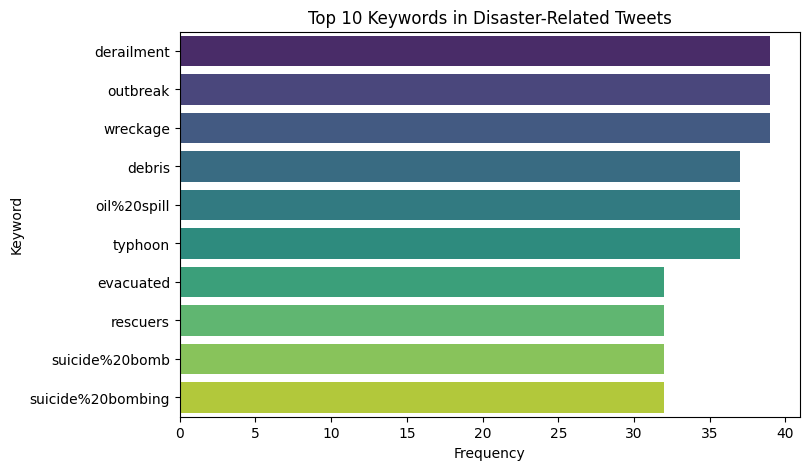

In [ ]:
#from collections import Counter

# Filter disaster-related tweets
disaster_tweets = df[df['target'] == 1]

# Count the most common keywords in disaster tweets
keyword_counts = Counter(disaster_tweets['keyword'].dropna())
most_common_keywords = keyword_counts.most_common(10)

# Create a DataFrame for visualization
keywords_df = pd.DataFrame(most_common_keywords, columns=['Keyword', 'Frequency'])

# Plot the most common keywords
plt.figure(figsize=(8, 5))
sns.barplot(data=keywords_df, x='Frequency', y='Keyword', palette='viridis')
plt.title('Top 10 Keywords in Disaster-Related Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()


 just for a view top most common keywords  

We only use text and target column of dataset for rest of our work as there lot's of null values inside other columns. As the objective of the project we need to work on text (tweet reviwe).

In [ ]:
data = df[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Data Exploration

 Visualising counts of real and fake tweets

In [ ]:
#import plotly.express as px

In [ ]:
fig = px.bar(x=["0","1"], y=data["target"].value_counts(),color=["red", "goldenrod"])

#Change this value for bar widths
for dt in fig.data:
    dt["width"] = 0.4

fig.update_layout(
    title_text = "Counts for Disaster and Non-Disaster Tweets",
    title_x=0.5,
    width=800,
    height=550,
    xaxis_title="Targets",
    yaxis_title="Count",
    showlegend=False
).show()

non-disater tweets(fake) are greater then disater tweets(real)

 # Visualising lengths of tweets

 Analyzing lengths of words in a tweets according to it being real or fake target value by ploting histograms

In [ ]:
import plotly.graph_objs as go

In [ ]:
from plotly.subplots import make_subplots

word_len_dis = data[data['target']==1]['text'].str.split().map(lambda x : len(x))

word_len_non_dis = data[data['target']==0]['text'].str.split().map(lambda x : len(x))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
            go.Histogram(x=word_len_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=1
).add_trace(
            go.Histogram(x=word_len_non_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=2
).update_layout(title_text="Length of words in Tweets",title_x=0.5,showlegend=False).show()




Disaster tweets length is greater  then non-disaster tweets length

In [ ]:
import plotly.figure_factory as ff

# Visualising average word lengths of tweets

Checking average word length for both type of tweets


In [ ]:
def avgwordlen(strlist):
    sum=[]
    for i in strlist:
        sum.append(len(i))
    return sum

avgword_len_dis = data[data['target']==1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

avgword_len_non_dis = data[data['target']==0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], group_labels, bin_size=.2, colors=colors,)

fig.update_layout(title_text="Average word length in tweets",title_x=0.5,xaxis_title="Text",yaxis_title="Density").show()



Average length of disaster tweets  is more then non disaster tweets

# Visualising most common stop words in the text data

What is a corpus?

In linguistics and NLP, corpus (literally Latin for body) refers to a collection of texts.
Such collections may be formed of a single language of texts, or can span multiple languages

Function for creating sample corpus for further analysis.

In [ ]:
def create_corpus(target):
    corpus = []
    for i in data[data['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

#  What are stopwords?

In computing, stop words are words that are filtered out before or after the natural language data (text) are processed.
While “stop words” typically refers to the most common words in a language, all-natural language processing tools don't use a single universal list of stop words.

Analysing most occuring stop words in the text using corpus creating function(create_corpus)

In [ ]:
from collections import defaultdict

In [ ]:
def create_corpus(target):
    """
    Stop words are commonly used words filtered out before or after the natural language data (text) are processed.
    """
    corpus = []
    for i in data[data['target']==target]['text'].str.split(): # Accessing the text column from the DataFrame
        for x in i:
            corpus.append(x)
    return corpus

values_list = []

def analyze_stopwords(data,func,targetlist):

  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label]) # This line is passing the integer to create_corpus
    dic = defaultdict(int)

    for word in corpus:
        if isinstance(word, str): # Make sure the word is string before calling lower()
            dic[word.lower()] += 1  # This was causing the error when word was not a string
        else:
            # Handle the case where word is not a string, e.g., print a warning or skip it
            print(f"Warning: Non-string word encountered: {word}, type: {type(word)}")
            # Or, if you want to skip non-string words:
            # pass


    top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
    x_items,y_values = zip(*top)
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing stopwords for 0 and 1 target labels
analyze_stopwords(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
      go.Bar(x=values_list[1],y=values_list[0],orientation='h',marker=dict(color= 'rgba(152, 255, 74,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[3],y=values_list[2],orientation='h',marker=dict(color= 'rgba(255, 143, 92,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top stop words in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top stop words in the text',auto_open=False,show_link=False)

The Bar Charts displays the top 10 stop words in tweets where 'the' is most frequent in both groups

# Visualising most common punctuations in the text data

In [ ]:
#!pip install nltk
#import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#import pandas as pd
#from collections import defaultdict
from string import punctuation

# Assuming 'df' is your original DataFrame (from pd.read_csv)
#data = df[['text', 'target']]  # Restore 'data' if it's not already a DataFrame

# Restored create_corpus function (original implementation):
def create_corpus(target):
    """
    Stop words are commonly used words filtered out before or after the natural language data (text) are processed.
    """
    corpus = []
    # Access the original DataFrame 'df' instead of the overwritten 'data'
    for i in df[df['target'] == target]['text'].str.split():  # Accessing the text column from the DataFrame
        for x in i:
            corpus.append(x)
    return corpus

# analyze_punctuations function:
def analyze_punctuations(data, func, targetlist):
    values_list = []  # Initialize values_list inside the function

    for label in range(0, len(targetlist)):
        corpus = func(targetlist[label])
        dic = defaultdict(int)

        for word in corpus:
            if word in punctuation:
                dic[word] += 1
        x_items, y_values = zip(*dic.items())
        values_list.extend([x_items, y_values])  # Use extend to add items to values_list

    return values_list  # Return the populated values_list

#analyzing punctuations for 0 and 1 target labels
values_list = analyze_punctuations(df, create_corpus, [0, 1])  # Use 'df' here as well

In [ ]:
analyze_punctuations(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
      go.Bar(x=values_list[0],y=values_list[1],
             marker=dict(color= 'rgba(196, 94, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[2],y=values_list[3],
             marker=dict(color= 'rgba(255, 163, 102,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top Punctuations in the text",title_x=0.5,showlegend=False).show()



# Data Cleaning

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Removing unwanted text using regular expressions

What is Stemming?

Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.
Stemming is important in natural language understanding (NLU) and natural language processing (NLP). Here we use SnowballStemmer.

Function for cleaning the data, we use RegEx i.e. re python library and SnowballStemmer() to stem the words.

In [ ]:
stemmer = SnowballStemmer("english")

def preprocess_data(data):

# removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data)

    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)

    #removal of html tags
    text = re.sub(r'<.*?>',' ',text)

    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emotions
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)

    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(r"\([^()]*\)", "", text)

    # remove mentions
    text = re.sub('@\S+', '', text)

    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)


    # Lowering all the words in text
    text = text.lower()
    text = text.split()

    text = [stemmer.stem(words) for words in text if words not in stopwords.words('english')]

    # Removal of words with length<2
    text = [i for i in text if len(i)>2]
    text = ' '.join(text)
    return text

data["Cleaned_text"] = df["text"].apply(preprocess_data)

In [ ]:
data.head(10)

,text,target,Cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv
1,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada
2,All residents asked to 'shelter in place' are ...,1,resid ask ishelt place notifi offic evacu shel...
3,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfir updat california hwi close direct due...
6,#flood #disaster Heavy rain causes flash flood...,1,flood disast heavi rain caus flash flood stree...
7,I'm on top of the hill and I can see a fire in...,1,top hill see fire wood
8,There's an emergency evacuation happening now ...,1,emerg evacu happen build across street
9,I'm afraid that the tornado is coming to our a...,1,afraid tornado come area


# Extra Data Exploration and Analysis on Cleaned Text

 Creating function and data for visualising words

Using the popular WordCloud python library for visulaising the cleaned data

In [ ]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
#import matplotlib.pyplot as plt

In [ ]:
def wordcloud(data,title):
    words = ' '.join(data['Cleaned_text'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()

data_disaster = data[data['target'] == 1]
data_non_disaster = data[data['target'] == 0]

# Visualising words inside Real Disaster Tweets

we can see that most common words in disaster tweets are fire,storm,flood , police etc.

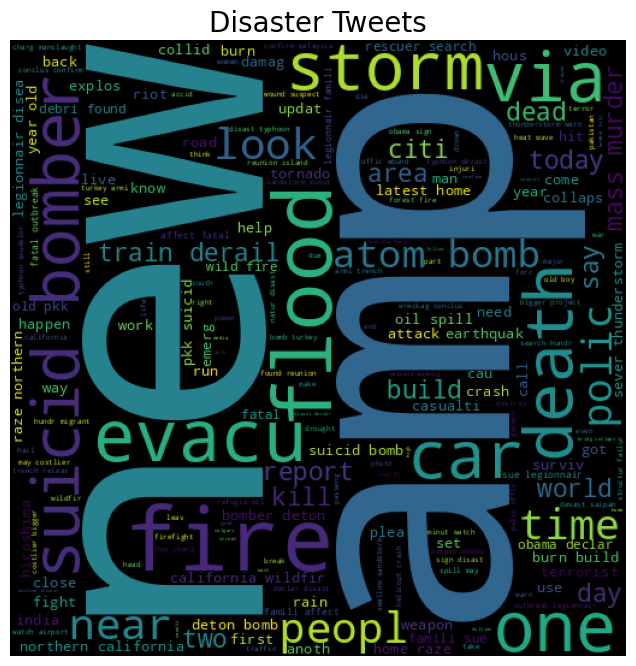

In [ ]:
wordcloud(data_disaster,"Disaster Tweets")

suicid,death,bomb,police,strom,people,fire,burn etc.

#Visualising words inside Non Disaster Tweets

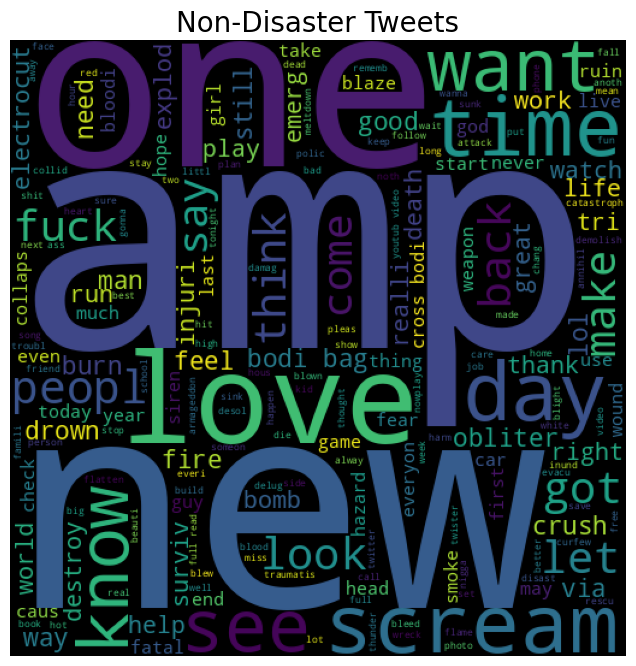

In [ ]:
wordcloud(data_non_disaster,"Non-Disaster Tweets")



love,new,time etc are the most common words as we can see in wordcloud of Non-disaster tweets

# Removing unwanted words with high frequency

Our cleaned text still contains some unnecessary words (such as: like, amp, get, would etc.) that aren't relevant and can confuse our model,
resulting in false prediction. Now, we will further remove some words with high frequency from text based on above charts.

In [ ]:
common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["Cleaned_text"] = data["Cleaned_text"].apply(text_cleaning)

In [ ]:
# chack now how looks our data after removing the high frequency

print(data.loc[0, "Cleaned_text"])

deed reason earthquak allah forgiv


In [ ]:
print(data[["text", "Cleaned_text"]].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        Cleaned_text  
0                 deed reason earthquak allah forgiv  
1                  forest fire near rong sask canada  
2  resid ask ishelt place notifi offic evacu shel...  
3        peopl receiv wildfir evacu order california  
4   sent photo rubi alaska smoke wildfir pour school  


In [ ]:
print(" ".join(data["Cleaned_text"].head(10)))

deed reason earthquak allah forgiv forest fire near rong sask canada resid ask ishelt place notifi offic evacu shelter place order expect peopl receiv wildfir evacu order california sent photo rubi alaska smoke wildfir pour school rockyfir updat california hwi close direct due lake counti fire cafir wildfir flood disast heavi rain caus flash flood street manitou colorado spring area top hill fire wood emerg evacu happen across street afraid tornado area


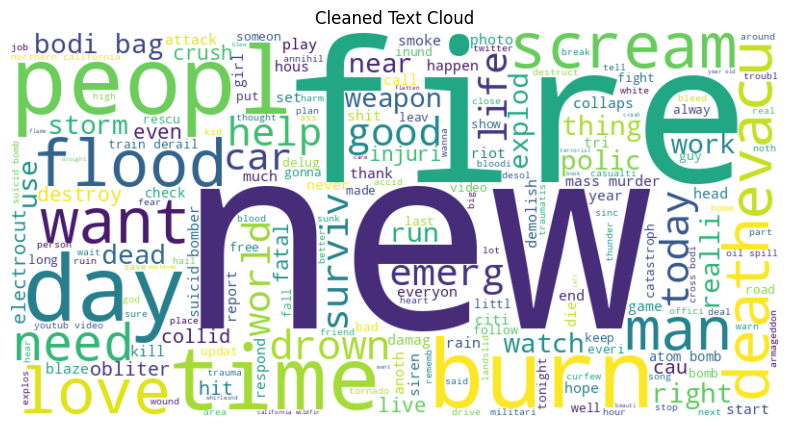

In [ ]:
#from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# Combine all cleaned text into a single string
all_text = " ".join(data["Cleaned_text"])


# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Cleaned Text Cloud')
plt.axis('off')
plt.show()
#

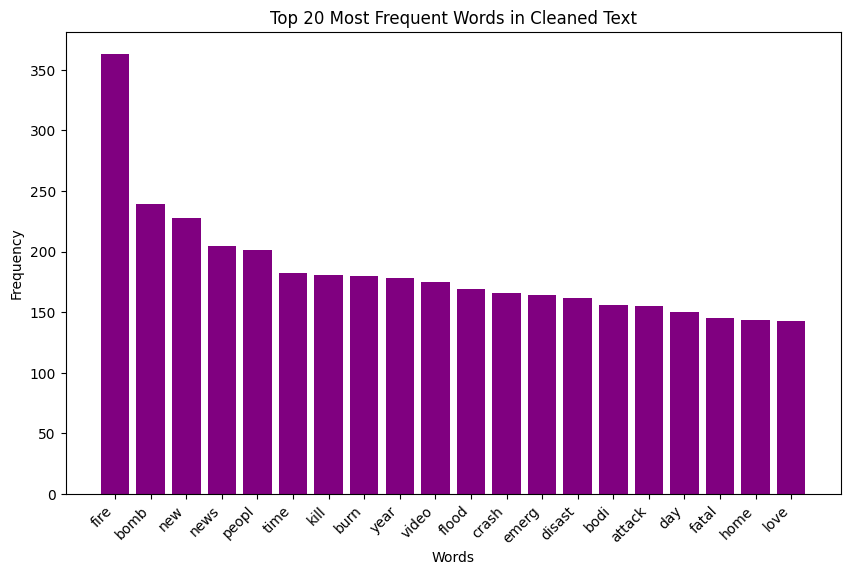

In [ ]:
#from collections import Counter

# Tokenize the cleaned text
all_words = " ".join(data["Cleaned_text"]).split()

# Count word frequencies
word_counts = Counter(all_words).most_common(20)  # Top 20 words

# Separate words and counts for plotting
words, counts = zip(*word_counts)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='purple')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Words in Cleaned Text")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


# Before-and-After Word Cloud
If you have both original and cleaned text, compare them side-by-side using word clouds.

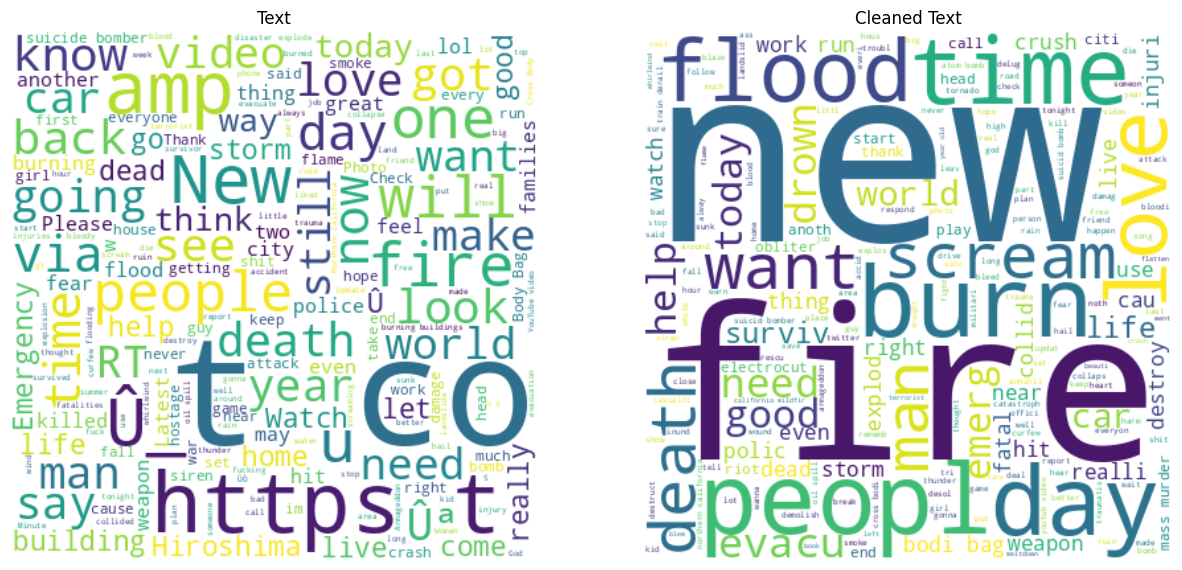

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Original text word cloud
original_text = " ".join(data["text"])
wordcloud_orig = WordCloud(width=400, height=400, background_color='white').generate(original_text)
ax[0].imshow(wordcloud_orig, interpolation='bilinear')
ax[0].set_title("Text")
ax[0].axis('off')

# Cleaned text word cloud
wordcloud_cleaned = WordCloud(width=400, height=400, background_color='white').generate(all_text)
ax[1].imshow(wordcloud_cleaned, interpolation='bilinear')
ax[1].set_title("Cleaned Text")
ax[1].axis('off')

plt.show()


#Bigram or Trigram Visualization
Visualize word pairs (bigrams) or triples (trigrams) for deeper insights.

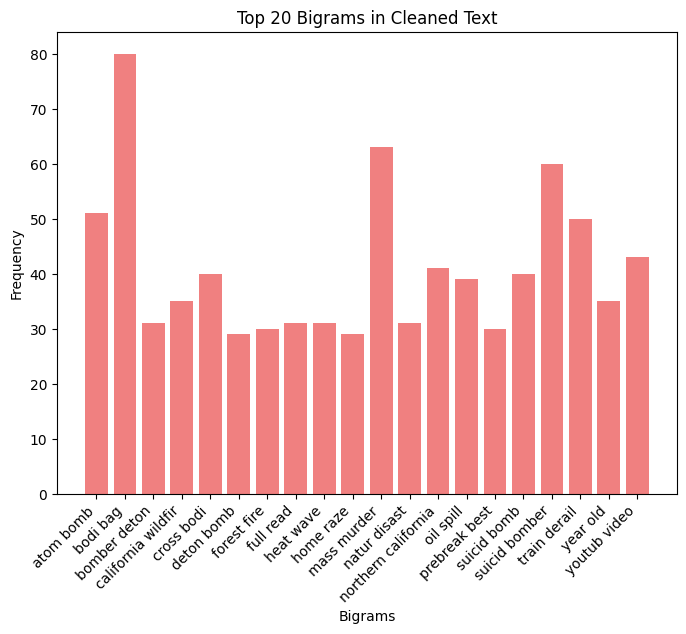

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)
bigrams = vectorizer.fit_transform(data["Cleaned_text"])
bigram_counts = bigrams.toarray().sum(axis=0)

# Plot the bigram frequencies
plt.figure(figsize=(8,6))
plt.bar(vectorizer.get_feature_names_out(), bigram_counts, color='lightcoral')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Bigrams in Cleaned Text")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.show()


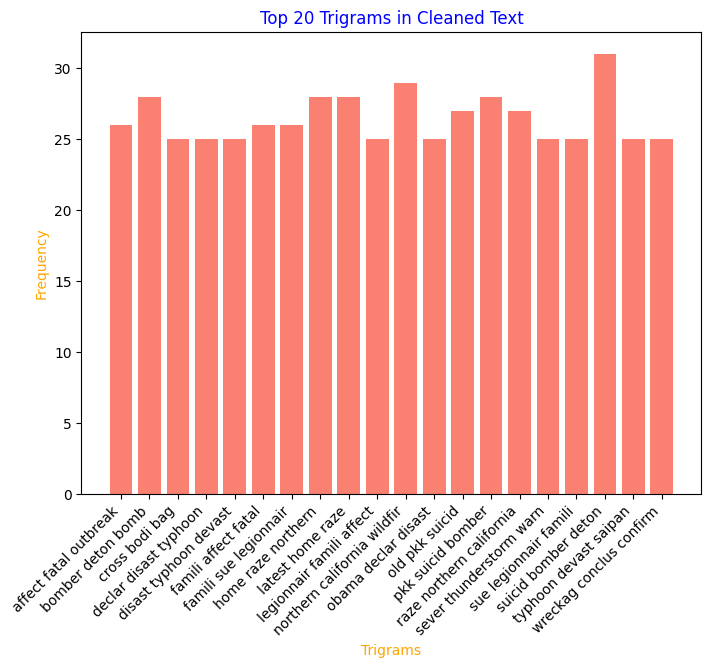

In [ ]:
# Extract bigrams
vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=20)
trigrams = vectorizer.fit_transform(data["Cleaned_text"])
trigram_counts = trigrams.toarray().sum(axis=0)

# Plot the bigram frequencies
plt.figure(figsize=(8,6))
plt.bar(vectorizer.get_feature_names_out(), trigram_counts, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Trigrams in Cleaned Text",color='blue')
plt.xlabel("Trigrams",color='orange')
plt.ylabel("Frequency", color='orange')
plt.show()

# Analysing top 10 N-grams where N is 1,2,3

@ What do you mean by N-grams?

N-grams of texts are extensively used in text mining and natural language processing tasks. They are basically a set of co-occurring words within a given window and when computing the n-grams you typically move one word forward (although you can move X words forward in more advanced scenarios).

In [ ]:
# perform N-grams analysis on cleaned data

def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

Creating data of top 10 n-grams for n = 1, 2, 3

In [ ]:
common_uni = top_ngrams(data["Cleaned_text"],10,1)
common_bi = top_ngrams(data["Cleaned_text"],10,2)
common_tri = top_ngrams(data["Cleaned_text"],10,3)
common_uni_df = pd.DataFrame(common_uni,columns=['word','freq'])
common_bi_df = pd.DataFrame(common_bi,columns=['word','freq'])
common_tri_df = pd.DataFrame(common_tri,columns=['word','freq'])

# Visualising top 10 N-grams for N = 1, 2, 3

In [ ]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Top 20 Unigrams in Text", "Top 20 Bigrams in Text","Top 20 Trigrams in Text"))

fig.add_trace(
      go.Bar(x=common_uni_df["word"],y=common_uni_df["freq"],
             marker=dict(color= 'rgba(255, 170, 59,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=common_bi_df["word"],y=common_bi_df["freq"],
             marker=dict(color= 'rgba(89, 255, 147,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=2, col=1
).add_trace(
      go.Bar(x=common_tri_df["word"],y=common_tri_df["freq"],
             marker=dict(color= 'rgba(89, 153, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=3, col=1
).update_layout(title_text="Visualization of Top 20 Unigrams, Bigrams and Trigrams",
                title_x=0.5,showlegend=False,width=800,height=1600,).update_xaxes(tickangle=-90).show()



In [ ]:
# save cleand preprocess data for next steps
#data.to_csv('cleaned_text.csv',index=False)



In [ ]:
#from google.colab import files

# Download the CSV file
#files.download('cleaned_text.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Preprocessing

Spliting original data after cleaning


In [ ]:
X_inp_clean = data['Cleaned_text']
X_inp_original = data['text']
y_inp = data['target']

Using scikit-learn's train_test_split to split the data into training and validation dataset

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_inp_clean, y_inp, test_size=0.2, random_state=42, stratify=y_inp)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

checking size of data after train test split

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6090,), (1523,), (6090,), (1523,))

# Creating function to encode data using BoW or TF-IDF

@ What is BoW?

BoW stands for "bag of words" which is a representation of text that describes the occurrence of words within a document.
We just keep track of word counts and disregard the grammatical details and the word order.
It is called a “bag” of words because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

@ What is TF-IDF?

TF-IDF which means Term Frequency and Inverse Document Frequency, is a scoring measure widely used in information retrieval (IR) or summarization.
TF-IDF is intended to reflect how relevant a term is in a given document. It is a technique in Natural Language Processing for converting words in Vectors and with some semantic information and it gives weighted to uncommon words , used in various NLP applications.

For BoW approach we use scikit-learn's CountVectorizer and for TF-IDF we use TfidfVectorizer

In [ ]:
def encoding(train_data,valid_data,bow=False,n=1,tf_idf=False):
    if bow==True:
        cv = CountVectorizer(ngram_range=(n,n))
        cv_df_train = cv.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(cv_df_train,columns=cv.get_feature_names_out())
        cv_df_valid = cv.transform(valid_data).toarray()
        valid_df = pd.DataFrame(cv_df_valid,columns=cv.get_feature_names_out())

    elif tf_idf==True:

        tfidf = TfidfVectorizer(ngram_range=(n, n), use_idf=True,smooth_idf=True,sublinear_tf=True)
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names_out())
        tf_df_valid = tfidf.transform(valid_data).toarray()
        valid_df = pd.DataFrame(tf_df_valid,columns=tfidf.get_feature_names_out())

    return train_df,valid_df

# Encoding training and validation data

We encode our data in all possible combinations provided by our function

In [ ]:
X_train_bow1 , X_valid_bow1 = encoding(X_train,X_valid,bow=True)
X_train_bow2 , X_valid_bow2 = encoding(X_train,X_valid,bow=True,n=2)
X_train_bow3 , X_valid_bow3 = encoding(X_train,X_valid,bow=True,n=3)
X_train_tfidf1 , X_valid_tfidf1 = encoding(X_train,X_valid,tf_idf=True)
X_train_tfidf2 , X_valid_tfidf2 = encoding(X_train,X_valid,tf_idf=True,n=2)
X_train_tfidf3 , X_valid_tfidf3 = encoding(X_train,X_valid,tf_idf=True,n=3)

# Training and tuning Machine Learining Models

@What is a classification report?

A Classification report is used to measure the quality of predictions from a classification algorithm.
The report shows the main classification metrics precision, recall and f1-score on a per-class basis. The metrics are calculated by using true and false positives, true and false negatives. Positive and negative in this case are generic names for the predicted classes.

@ What is a confusion matrix?

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

*In a confusion matrix there are 4 basic terminologies :
true positives (TP) : We predicted yes (they are real tweets), and they are actually real.

true negatives (TN) : We predicted no, and they are fake.

false positives (FP): We predicted yes, but they are't actually real. (Also known as a "Type I error.")

false negatives (FN): We predicted no, but they are real. (Also known as a "Type II error.")

Now let's create functions to display model's classification report and confusion matrix

In [ ]:
def c_report(y_true,y_pred):
    print("Classifictaion Report")
    print(classification_report(y_true, y_pred))
    acc_scr = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_scr))
    return acc_scr

def plot_cm(y_true,y_pred,cmap = "Blues"):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot = True, fmt='d', linewidth=0.5,
               cmap=cmap, cbar = False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Logistic Regression

About Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary). Like all regression analyses, the logistic regression is a predictive analysis. Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Now let's create a Logistic Regression model and train it.

In [ ]:
model_bow1_logreg = LogisticRegression()
model_bow1_logreg.fit(X_train_bow1,y_train)
pred_bow1_logreg = model_bow1_logreg.predict(X_valid_bow1)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(BoW,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       869
           1       0.82      0.73      0.77       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.81      0.81      0.81      1523

Accuracy : 0.81483913328956


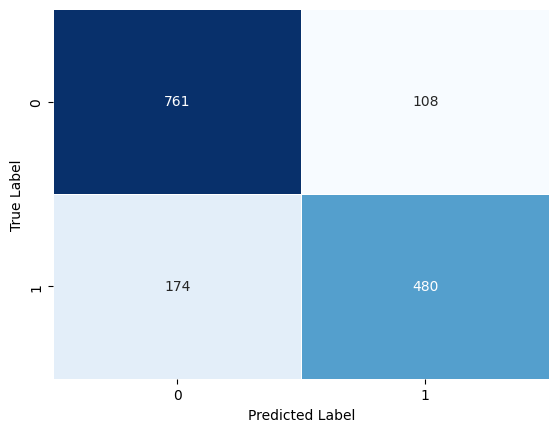

In [ ]:
acc_bow1_logreg = c_report(y_valid,pred_bow1_logreg)
plot_cm(y_valid,pred_bow1_logreg)

Now training another Logistic Regression model with n-grams=2 and BoW

In [ ]:
model_bow2_logreg = LogisticRegression()
model_bow2_logreg.fit(X_train_bow2,y_train)
pred_bow2_logreg = model_bow2_logreg.predict(X_valid_bow2)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(BoW,n-grams=2) model



Classifictaion Report
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       869
           1       0.89      0.45      0.60       654

    accuracy                           0.74      1523
   macro avg       0.80      0.71      0.70      1523
weighted avg       0.78      0.74      0.72      1523

Accuracy : 0.7413000656598818


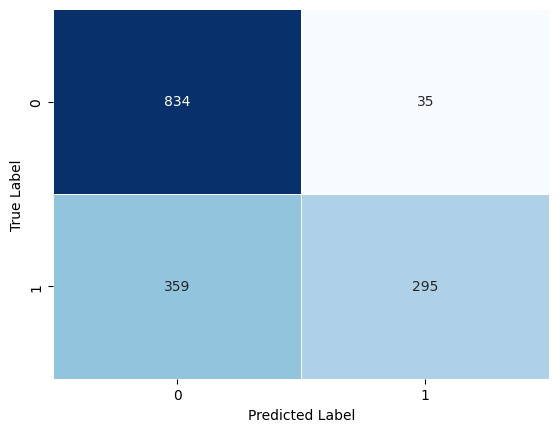

In [ ]:
acc_bow2_logreg = c_report(y_valid,pred_bow2_logreg)
plot_cm(y_valid,pred_bow2_logreg)

We can observe that as n is increasing model accuracy is decreasing
let's try to increase n one last time just to be sure

In [ ]:
model_bow3_logreg = LogisticRegression()
model_bow3_logreg.fit(X_train_bow3,y_train)
pred_bow3_logreg = model_bow3_logreg.predict(X_valid_bow3)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(BoW,n-grams=3) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       869
           1       0.92      0.33      0.49       654

    accuracy                           0.70      1523
   macro avg       0.79      0.66      0.64      1523
weighted avg       0.77      0.70      0.66      1523

Accuracy : 0.7019041365725541


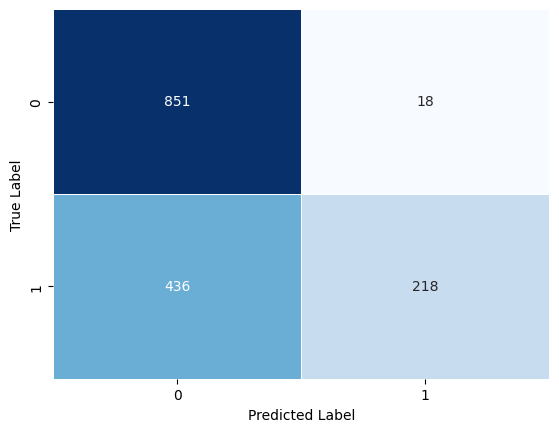

In [ ]:
acc_bow3_logreg = c_report(y_valid,pred_bow3_logreg)
plot_cm(y_valid,pred_bow3_logreg)

# From the above results it's clear that using n = 1(n-grams) will always give us more accuray,

**@ now let's use tfidf approach with n = 1 to train our Logistic Regression model**

In [ ]:
model_tfidf1_logreg = LogisticRegression(C=1.0)
model_tfidf1_logreg.fit(X_train_tfidf1,y_train)
pred_tfidf1_logreg = model_tfidf1_logreg.predict(X_valid_tfidf1)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(TF-IDF,n-grams=1) model



Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       869
           1       0.85      0.71      0.78       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.82      0.82      1523

Accuracy : 0.8233749179251477


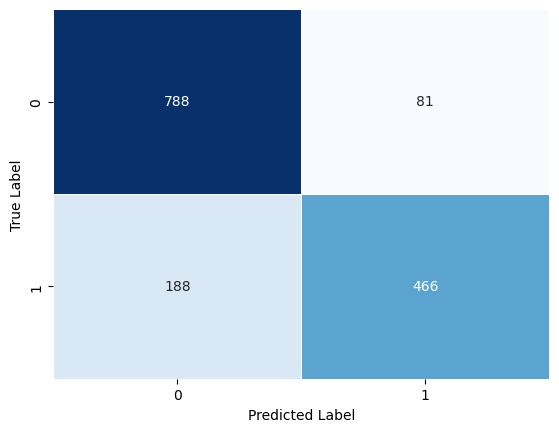

In [ ]:
acc_tfidf1_logreg = c_report(y_valid,pred_tfidf1_logreg)
plot_cm(y_valid,pred_tfidf1_logreg)

**From Logistic Regression we saw n-grams = 1 gives the best results**

# Multinomial Naive Bayes

About Multinomial Naive Bayes

Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP). The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article. It calculates the probability of each tag for a given sample and then gives the tag with the highest probability as output.

Naive Bayes classifier is a collection of many algorithms where all the algorithms share one common principle, and that is each feature being classified is not related to any other feature. The presence or absence of a feature does not affect the presence or absence of the other feature.

Now let's create MultinomialNB model and train it.

In [ ]:
model_bow1_NB = MultinomialNB(alpha=0.7)
model_bow1_NB.fit(X_train_bow1,y_train)
pred_bow1_NB = model_bow1_NB.predict(X_valid_bow1)

MultinomialNB(alpha=0.7)

Printing classification report and ploting confusion matrix for the predictions of MultinomialNB(BoW,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       869
           1       0.79      0.76      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.81      1523
weighted avg       0.81      0.81      0.81      1523

Accuracy : 0.8108995403808273


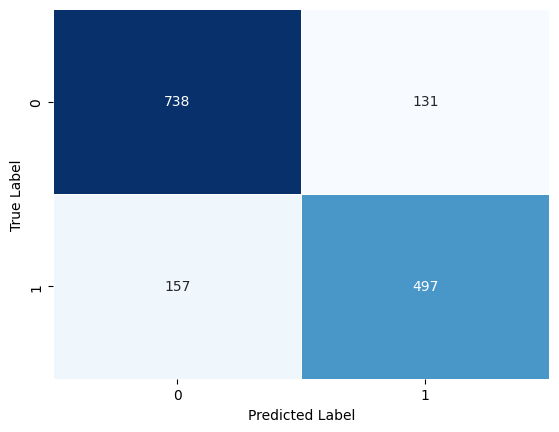

In [ ]:
acc_bow1_NB = c_report(y_valid,pred_bow1_NB)
plot_cm(y_valid,pred_bow1_NB)

Creating a MultinomialNB model and training it with TF-IDF approach

In [ ]:
model_tfidf1_NB = MultinomialNB(alpha=0.7)
model_tfidf1_NB.fit(X_train_tfidf1,y_train)
pred_tfidf1_NB = model_tfidf1_NB.predict(X_valid_tfidf1)


MultinomialNB(alpha=0.7)

Printing classification report and ploting confusion matrix for the predictions of MultinomialNB(TF-IDF,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523

Accuracy : 0.8135259356533159


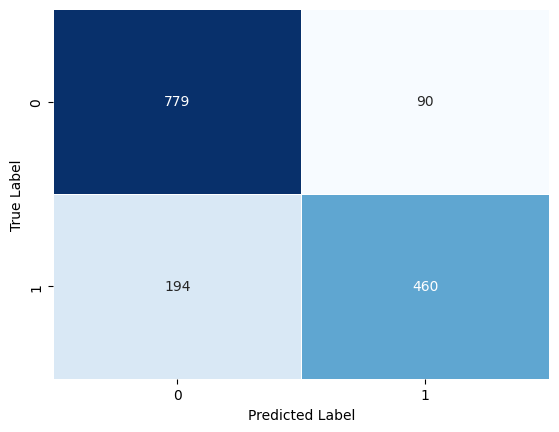

In [ ]:
acc_tfidf1_NB = c_report(y_valid,pred_tfidf1_NB)
plot_cm(y_valid,pred_tfidf1_NB)

# Random Forest Classifier

About Random Forest Classifier

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

Random forests has a variety of applications, such as recommendation engines, image classification and feature selection. It can be used to classify loyal loan applicants, identify fraudulent activity and predict diseases. It lies at the base of the Boruta algorithm, which selects important features in a dataset.

Now let's create a RandomForestClassifier model and train it.

In [ ]:
model_tfidf1_RFC = RandomForestClassifier()
model_tfidf1_RFC.fit(X_train_tfidf1,y_train)
pred_tfidf1_RFC = model_tfidf1_RFC.predict(X_valid_tfidf1)

RandomForestClassifier()

Printing classification report and ploting confusion matrix for predictions of RandomForestClassifier model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.70      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy : 0.8010505581089954


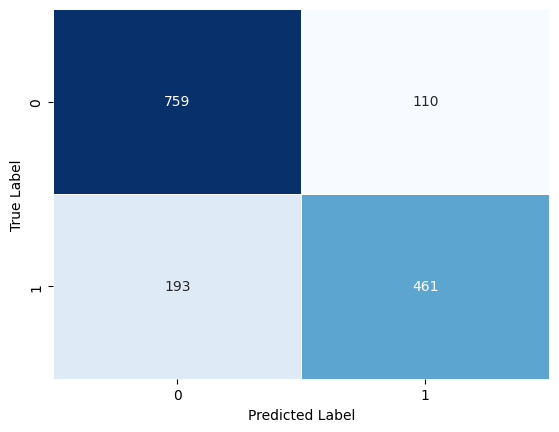

In [ ]:
acc_tfidf1_RFC = c_report(y_valid,pred_tfidf1_RFC)
plot_cm(y_valid,pred_tfidf1_RFC)

# eXtreme Gradient Boosting Classifier

About XGBClassifier

The XGBoost stands for eXtreme Gradient Boosting, which is a boosting algorithm based on gradient boosted decision trees algorithm.
XGBoost applies a better regularization technique to reduce overfitting, and it is one of the differences from the gradient boosting.

Now let's create a XGBClassifier model and train it.

In [ ]:
model_tfidf1_XGB = XGBClassifier(eval_metric='mlogloss')
model_tfidf1_XGB.fit(X_train_tfidf1,y_train)
pred_tfidf1_XGB = model_tfidf1_XGB.predict(X_valid_tfidf1)

Printing classification report and ploting confusion matrix for the predictions made by the XGBClassifier model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       869
           1       0.81      0.66      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523

Accuracy : 0.7872619829284307


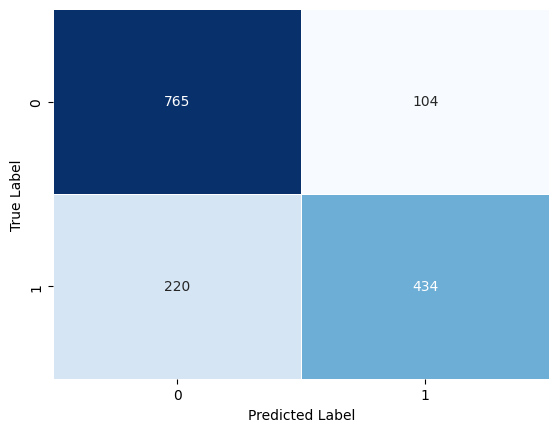

In [ ]:
acc_tfidf1_XGB = c_report(y_valid,pred_tfidf1_XGB)
plot_cm(y_valid,pred_tfidf1_XGB)

# Support Vector CLassifier

# About SVC
SVM offers very high accuracy compared to other classifiers such as logistic regression, and decision trees. It is known for its kernel trick to handle nonlinear input spaces. It is used in a variety of applications such as face detection, intrusion detection, classification of emails, news articles and web pages, classification of genes, and handwriting recognition.

SVM is an exciting algorithm and the concepts are relatively simple. The classifier separates data points using a hyperplane with the largest amount of margin. That's why an SVM classifier is also known as a discriminative classifier. SVM finds an optimal hyperplane which helps in classifying new data points.   

Now let's create a [SVC] model and training it.

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_tfidf1_SVC = SVC(kernel='linear', degree=3, gamma='auto')
model_tfidf1_SVC.fit(X_train_tfidf1,y_train)
pred_tfidf1_SVC = model_tfidf1_SVC.predict(X_valid_tfidf1)

Printing classification report and ploting confusion matrix for the SVC model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       869
           1       0.83      0.74      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Accuracy : 0.8214051214707814


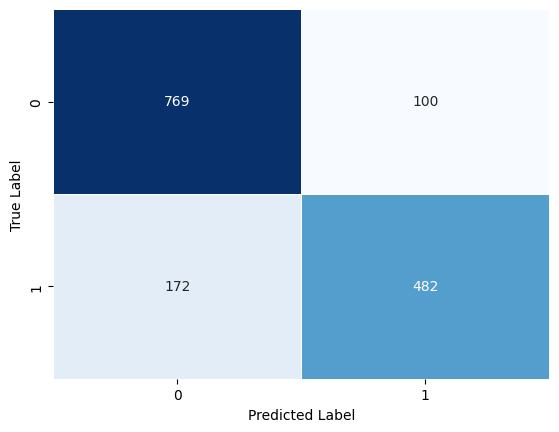

In [ ]:
acc_tfidf1_SVC = c_report(y_valid,pred_tfidf1_SVC)
plot_cm(y_valid,pred_tfidf1_SVC)

# Voting Classifier

### About Voting Classifier

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on    
their highest probability of chosen class as the output. It simply aggregates the findings of each classifier passed into Voting Classifier    
and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

#### Voting Classifier supports two types of votings :  


* **Hard Voting** : In hard voting, the predicted output class is a class with the highest majority of votes i.e the class    which had the highest probability of being predicted by each of the classifiers. Suppose three classifiers predicted the output class(A, A, B), so here the majority predicted A as output. Hence A will be the final prediction.


* **Soft Voting** : In soft voting, the output class is the prediction based on the average of probability given to that class. Suppose given some input to three models, the prediction probability for class A = (0.30, 0.47, 0.53) and B = (0.20, 0.32, 0.40). So the average for class A is 0.4333 and B is 0.3067, the winner is clearly class A because it had the highest probability averaged by each classifier


Now let's create a [VotingClassifier](https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/) with soft voting and train it

In [ ]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
#!pip install --upgrade xgboost

In [ ]:
!pip install numpy scipy

In [ ]:
!pip install scikit-learn==0.24.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
#!pip install --upgrade scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
# Combine Optimized Models in Voting Classifier


In [ ]:
from sklearn.ensemble import VotingClassifier


estimators = []
estimators.append(('LR',
                  LogisticRegression()))
estimators.append(('NB', MultinomialNB(alpha=0.7)))
estimators.append(('XBG', XGBClassifier(eval_metric='mlogloss')))

model_tfidf1_VC = VotingClassifier(estimators=estimators,voting='soft')
model_tfidf1_VC.fit(X_train_tfidf1,y_train)
pred_tfidf1_VC = model_tfidf1_VC.predict(X_valid_tfidf1)

print("Optimized Voting Classifier Accuracy:", accuracy_score(y_valid, pred_tfidf1_VC))


AttributeError: 'super' object has no attribute '__sklearn_tags__'

I tried many ways but due to session crash and above error i can't run it again.first time when it runs properly i serialise my model but i havn't download that time that is why i am unable to deploy this model for further steps.

Printing classification report and ploting confusion matrix for VotingClasssifier

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       869
           1       0.87      0.71      0.78       654

    accuracy                           0.83      1523
   macro avg       0.84      0.82      0.82      1523
weighted avg       0.84      0.83      0.83      1523

Accuracy : 0.8319107025607354


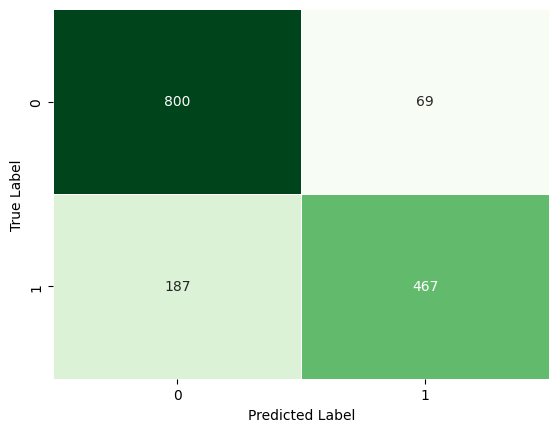

In [ ]:
acc_tfidf1_VC = c_report(y_valid,pred_tfidf1_VC)
plot_cm(y_valid,pred_tfidf1_VC,cmap = "Greens")

# Comparing the Accuracy of all models

In [ ]:
results = pd.DataFrame([["Logistic Regression BoW1",acc_bow1_logreg],["Logistic Regression BoW2",acc_bow2_logreg],
                       ["Logistic Regression BoW3",acc_bow3_logreg],["Logistic Regression Tf-Idf1",acc_tfidf1_logreg],
                       ["Naive Bayes Tf-Idf1",acc_tfidf1_NB],["Random Forest Tf-Idf1",acc_tfidf1_RFC],
                       ["XGBClassifier Tf-Idf1",acc_tfidf1_XGB],["SVC Tf-Idf1",acc_tfidf1_SVC],["Voting Tf-Idf1",acc_tfidf1_VC]],
                       columns = ["Models","Accuracy Score"]).sort_values(by='Accuracy Score',ascending=False)

results.style.background_gradient(cmap='Blues')

,Models,Accuracy Score
8,Voting Tf-Idf1,0.831911
7,SVC Tf-Idf1,0.821405
3,Logistic Regression Tf-Idf1,0.820749
0,Logistic Regression BoW1,0.816152
4,Naive Bayes Tf-Idf1,0.813526
5,Random Forest Tf-Idf1,0.803677
6,XGBClassifier Tf-Idf1,0.787262
1,Logistic Regression BoW2,0.740643
2,Logistic Regression BoW3,0.700591


# Conclusion
Among all Simple classification models used above Voting Classifier performed best with tf-idf with ngrams = 1

In [ ]:
# serialise the model


In [ ]:
import pickle

# Assuming 'voting_tfidf1_model' is your trained Voting Tf-Idf1 model object
model_filename = "Voting_Tf_idf1_model.pkl"

# Serialize the model to a file
with open(model_filename, 'wb') as model_file:
    pickle.dump(model_tfidf1_VC, model_file)

print(f"Model serialized and saved as '{model_filename}'")


Model serialized and saved as 'Voting_Tf_idf1_model.pkl'


In [ ]:
import logging
import pickle

# Set up logging
logger = logging.getLogger("ModelLogger")
logger.setLevel(logging.DEBUG)  # Set level to DEBUG to capture all events

# Create a file handler to save logs to a file
file_handler = logging.FileHandler("model_operations.log")
file_handler.setLevel(logging.DEBUG)

# Create a console handler for output to the terminal
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Define the logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

# Model serialization function
def serialize_model(model_tfidf1_VC,Voting_Tf_idf1_model.pkl):
    try:
        with open(filename, 'wb') as model_file:
            pickle.dump(model, model_file)
        logger.info(f"Model successfully serialized and saved to '{filename}'.")
    except Exception as e:
        logger.error(f"Failed to serialize the model: {e}")

# Model deserialization function
def deserialize_model(filename):
    try:
        with open(filename, 'rb') as model_file:
            model = pickle.load(model_file)
        logger.info(f"Model successfully deserialized from '{filename}'.")
        return model
    except Exception as e:
        logger.error(f"Failed to deserialize the model: {e}")
        return None
